##  SavedFeaturesSelectedBackward20to2_CC**

In [32]:
  


#dti_metric choose 'FA','MD','RD' or 'AD'
dti_metric='FA'
CC=5
nFeatures=5
RandomState=0
nclust=2

#KNN
num_shuffles = 2000
knn_test_size=0.1
looking_for_best_k=0
KN=6

#DECISION TREE
make_tree=0
make_jointplot=0


In [33]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import combinations
import scipy.stats as scs

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

import warnings
import matplotlib.pyplot as plt
import matplotlib as ml
import mpl_toolkits.mplot3d 
import matplotlib.gridspec as gridspec
warnings.filterwarnings('ignore')


from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, roc_auc_score)


if nFeatures=='auto':
    list_of_selfeatures=np.load('SavedFeaturesSelectedBackwardAuto_CC_'+str(CC)+'_'+dti_metric+'.npy',allow_pickle=True)
else:
    #list_of_selfeatures=np.load('SavedFeaturesSelectedBackward20to2_CC_'+str(CC)+'_'+dti_metric+'.npy',allow_pickle=True)
    list_of_selfeatures=np.load('SavedFeaturesSelectedBackward20to2_CC_'+str(CC)+'_'+'FA.npy',allow_pickle=True)

    list_of_selfeatures=list_of_selfeatures[nFeatures]


SubjectTable= pd.read_csv('Subject_preproc.csv', sep=",")

dataRaw = pd.read_csv('CC_'+str(CC) +'_'+dti_metric+'.csv', sep=",")

SelectedFeat=(list_of_selfeatures)

## create 2 groups of JND below and above median of JND q=2

labels = [0,1]
SubjectTable['JND_group'] = pd.qcut(SubjectTable['JND_P'], q=2, labels=labels)
SubjectTable['IHD_group'] = pd.qcut(SubjectTable['IHD'], q=2, labels=labels)



print(list_of_selfeatures)

data=pd.concat([dataRaw.loc[:,SelectedFeat], SubjectTable], axis=1)


Index(['5', '54', '56', '68', '69'], dtype='object')


## **KMEANS USING SavedFeaturesSelectedBackward_CC_X_Metrics**


In [34]:
dataCorrmat=data.drop(['sex','age','group_Y', 'group_O', 'JND_group', 'group','IHD_group'], axis=1)

cont=dataCorrmat.columns
corr_matrix=pd.DataFrame(dataCorrmat[cont],columns=cont).corr()

dataKmeans=data.drop(['sex','age','group_Y', 'group_O', 'JND_group', 'group','FA_body','MD_body','AD_body',
                      'RD_body','JND_P','IHD','IHD_group'], axis=1)

X=dataKmeans
dataKmeans.head()
data.columns
print(list_of_selfeatures)

#SCALING using a StandardScaler
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)
Xscaled = pd.DataFrame(Xscaled, columns=X.columns)

Xscaled.head()

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score

SilScore=[]
CalHar=[]
DavBouldin=[]
inertia=[]

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=RandomState).fit(Xscaled)
    SilScore.append(silhouette_score(Xscaled, kmeans.fit_predict(Xscaled)))
    CalHar.append(calinski_harabasz_score(Xscaled, kmeans.labels_))
    inertia.append(kmeans.inertia_)  # Inertie (cohésion)

K_range = range(2, 10)  
    
df = pd.DataFrame({'Silhouette Score': SilScore,'Inertia': inertia,
               'Cal.-Har. Index': CalHar,'N Cluster': K_range})


#KMEANS  
nclust=2
kmeans = KMeans(n_clusters=nclust, random_state=RandomState).fit(Xscaled)
kmeans.labels_
CenterCluster=kmeans.cluster_centers_
labels_CC = kmeans.labels_

data["cluster"]=labels_CC

#f1='FA_body'
#f2='RD_body'
#if CC==5:
#    f1='54'
#     f2='56'
#elif CC==4:
#    f1='26'
#    f2='27'

f1=list_of_selfeatures[0]
f2=list_of_selfeatures[1]


Index(['5', '54', '56', '68', '69'], dtype='object')


### PLOT CORRELATION MATRIX, CLUSTERS FOR A GIVEN CC (COMMON FOR ALL TARGET VAR)


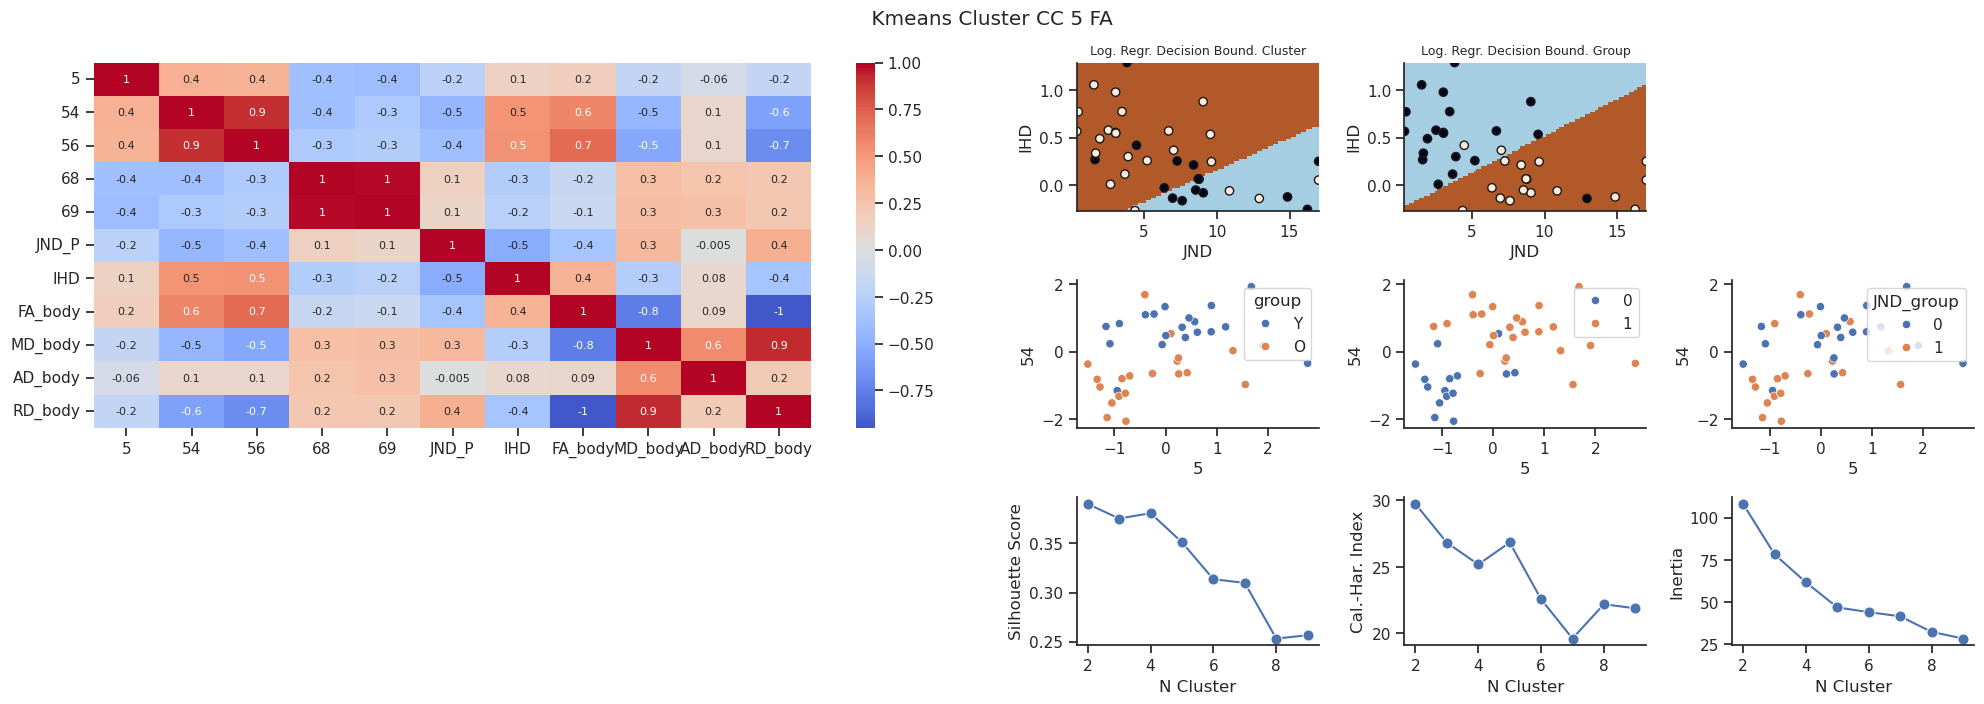

In [35]:
# PLOT CORRELATION MATRIX, CLUSTERS FOR A GIVEN CC (COMMON FOR ALL TARGET VAR)

from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression

fig = plt.figure(tight_layout=True,figsize=(20,10))

gs = gridspec.GridSpec(9, 6)

ax = fig.add_subplot(gs[0:4,0:3])

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True, annot_kws={'size': 8},
            fmt='.1g',ax=ax)
fig.suptitle('KNN CC '+str(CC)+' '+dti_metric )

# PLOT  Evaluation CLUSTERS 

ax = fig.add_subplot(gs[4:6,3])
sns.lineplot(ax=ax,data=df, y='Silhouette Score', x='N Cluster', marker='o',markersize=8)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(gs[4:6,4])
sns.lineplot(ax=ax,data=df, x='N Cluster', y='Cal.-Har. Index', marker='o',markersize=8)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(gs[4:6,5])
sns.lineplot(ax=ax,data=df, x='N Cluster', y='Inertia', marker='o',markersize=8)
ax.spines[['right', 'top']].set_visible(False)
fig.suptitle('KNN CC '+str(CC)+' '+dti_metric )

ax = fig.add_subplot(gs[2:4,3])
sns.scatterplot(ax=ax,data=Xscaled, x=f1, y=f2,hue=SubjectTable["group"]) 
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(gs[2:4,4])
sns.scatterplot(ax=ax,data=Xscaled, x=f1, y=f2,hue=labels_CC) 
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(gs[2:4,5])
sns.scatterplot(ax=ax,data=Xscaled, x=f1, y=f2,hue=SubjectTable["JND_group"]) 
ax.spines[['right', 'top']].set_visible(False)

sns.set_theme(style="ticks")


## PLOT DECISION BOUNDARY     JND vs IHD label group and cluster

SubjectTable["group"]
SubjectTable["cluster"]=labels_CC

X = SubjectTable[['JND_P', 'IHD']]

subplotid=0    

for targetVarid in [0,2]:

    if targetVarid==2:
        y = SubjectTable['cluster']
        ax = fig.add_subplot(gs[0:2,3])
        ax.set_title('Log. Regr. Decision Bound. Cluster',fontsize=9)

    elif targetVarid==0:
        y = SubjectTable['group_O']
        ax = fig.add_subplot(gs[0:2,4])
        ax.set_title('Log. Regr. Decision Bound. Group',fontsize=9)

    logreg = LogisticRegression(C=1e5)
    logreg.fit(X, y)
    DecisionBoundaryDisplay.from_estimator(logreg, X, cmap=plt.cm.Paired, ax=ax, response_method="predict", plot_method="pcolormesh", shading="auto",  xlabel="JND",  ylabel="IHD",  eps=0.5)
    ax.scatter(X['JND_P'], X['IHD'], c=y, edgecolors="k")
    ax.set_xlim(X['JND_P'].min(), X['JND_P'].max())
    ax.set_ylim(X['IHD'].min(), X['IHD'].max())
    ax.spines[['right', 'top']].set_visible(False)
    subplotid=subplotid+1

plt.suptitle(' Kmeans Cluster CC '+str(CC)+' '+dti_metric +' ')

namefig='KMeans Clustering CC '+str(CC)+' '+dti_metric

plt.tight_layout()

plt.savefig(namefig,format='pdf')

plt.show()



### **KNeighborsClassifier for a given CC / Run all targetVar / Evaluate K and score**

Evaluate for real data the appropriate K value for aa given targetvar

In [36]:
# KNN CLASSIFICATION  BEST K

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

 # TARGET VAR : 1: JND, 0 : GROUP, 2  CLUSTER, 3 IHD

targetVar=1

if targetVar==0:
    targetVarStr='Group'
    Y_group=data["group"] 
    targetnames=['Y','O']
elif targetVar==1:
    Y_group=data["JND_group"] 
    targetnames=['0','1']   
elif targetVar==2:
    targetVarStr='Cluster'
    Y_group=labels_CC
    targetnames=['1','2']   
    y=data["cluster"] 
elif targetVar==3:
    targetVarStr='IHD'
    Y_group=data["IHD_group"] 
    targetnames=['0','1']

    

X=Xscaled
y=Y_group

if looking_for_best_k==1:

        
    knn_K_num_shuffles = 200  ## MOVED in the top section 

    # List to store the accuracies
    K_Accuracy=[]
    K_Error_rate=[]
    minK=2
    maxK=12

    for n_neighbors in range(minK, maxK):
        accuracies = []
        accuracies_real = []
        score_real = []
        error_rate_real=[]

        cm_real = np.zeros((2,2))  

        for i in range(1,knn_K_num_shuffles):

            # Perform the shuffling and evaluation process multiple times

            X_shuffled, y_shuffled = X.sample(frac=1, random_state=i).values, y.sample(frac=1, random_state=i).values

            # Split the shuffled data into training and test sets
            X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=knn_test_size, random_state=0)

            # Create and train the KNeighborsClassifier
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)
            knn.fit(X_train, y_train)
            
            # Make predictions on the test data
            y_pred = knn.predict(X_test)

            # Evaluate the classifier
            accuracy = accuracy_score(y_test, y_pred)
            score=knn.score(X_test, y_test, sample_weight=None)
            cm=confusion_matrix(y_test, y_pred)
            error_rate=np.mean(y_pred != y_test)

            accuracies_real.append(accuracy)
            score_real.append(score)
            cm_real=cm_real+cm
            error_rate_real.append(error_rate)


        # Convert the list of accuracies to a numpy array for analysis
        accuracies = np.array(accuracies)
        K_Accuracy.append(np.mean(accuracies_real))
        K_Error_rate.append(np.mean(error_rate_real))

    




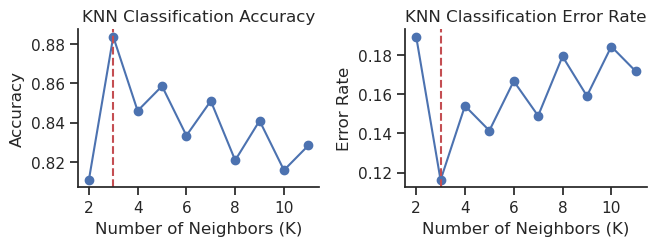

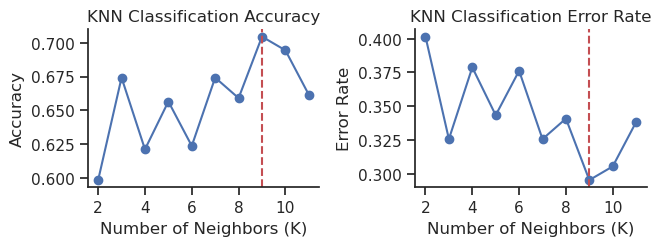

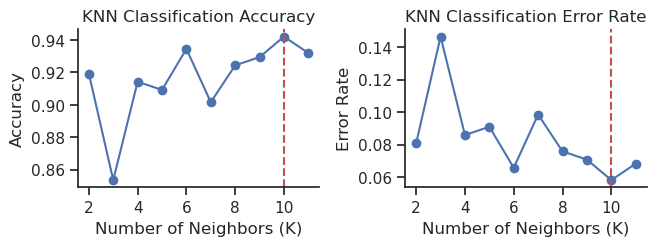

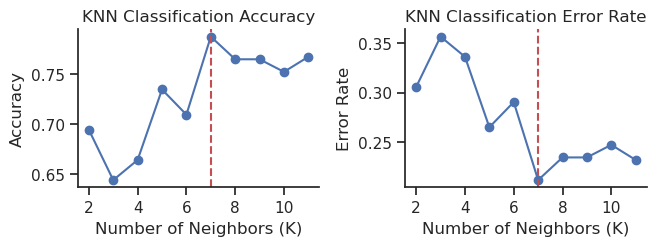

In [38]:
# KNN CLASSIFICATION
# used K defined by previous analysis


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score


# Function to shuffle the dataset and evaluate the classifier
def KNN_evaluate_shuffled_data(X, y, n_neighbors, test_size, random_state,shuffle):

    if shuffle==1:
        random_state2=0
    elif shuffle==0:
        random_state2=random_state
    
    # Shuffle the dataset
    X_shuffled, y_shuffled = X.sample(frac=1, random_state=random_state).values, y.sample(frac=1, random_state=random_state2).values

    # Split the shuffled data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=test_size, random_state=0)

    # Create and train the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = knn.predict(X_test)
    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    score=knn.score(X_test, y_test, sample_weight=None)
    cm=confusion_matrix(y_test, y_pred)
    error_rate=np.mean(y_pred != y_test)
    recall = recall_score(y_test, y_pred)

    return accuracy,score,cm,error_rate,recall




X=Xscaled


# TARGET VAR : 1: JND, 0 : GROUP, 2  CLUSTER, 3 IHD


num_shuffles = 200  ## MOVED in the top section 

accuracies_real_all=np.zeros((4,num_shuffles-1))
accuracies_shuff_all=np.zeros((4,num_shuffles-1))

cm_real_all=np.zeros((2,2,4))
cm_shuff_all=np.zeros((2,2,4))

recall_real_all=np.zeros((4,num_shuffles-1))
recall_shuff_all=np.zeros((4,num_shuffles-1))



for targetVar in [0,1,2,3]:

    if targetVar==0:
        targetVarStr='Group'
        Y_group=data["group_O"] 
        targetnames=['Y','O']
    elif targetVar==1:
        Y_group=data["JND_group"] 
        targetVarStr='JND'
        targetnames=['0','1']   
    elif targetVar==2:
        targetVarStr='Cluster'
        Y_group=labels_CC
        targetnames=['1','2']   
        Y_group=data["cluster"] 
    elif targetVar==3:
        targetVarStr='IHD'
        Y_group=data["IHD_group"] 
        targetnames=['0','1']

    y=Y_group

        
    
    knn_K_num_shuffles = 100  ## MOVED in the top section 

    # List to store the accuracies
    K_Accuracy=[]
    K_Error_rate=[]
    minK=2
    maxK=12

    for n_neighbors in range(minK, maxK):
        accuracies = []
        accuracies_real = []
        score_real = []
        error_rate_real=[]

        cm_real = np.zeros((2,2))  

        for i in range(1,knn_K_num_shuffles):

            # Perform the shuffling and evaluation process multiple times

            X_shuffled, y_shuffled = X.sample(frac=1, random_state=i).values, y.sample(frac=1, random_state=i).values

            # Split the shuffled data into training and test sets
            X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=knn_test_size, random_state=0)

            # Create and train the KNeighborsClassifier
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)
            knn.fit(X_train, y_train)
            
            # Make predictions on the test data
            y_pred = knn.predict(X_test)

            # Evaluate the classifier
            accuracy = accuracy_score(y_test, y_pred)
            score=knn.score(X_test, y_test, sample_weight=None)
            cm=confusion_matrix(y_test, y_pred)
            error_rate=np.mean(y_pred != y_test)

            accuracies_real.append(accuracy)
            score_real.append(score)
            cm_real=cm_real+cm
            error_rate_real.append(error_rate)


        # Convert the list of accuracies to a numpy array for analysis
        accuracies = np.array(accuracies)
        K_Accuracy.append(np.mean(accuracies_real))
        K_Error_rate.append(np.mean(error_rate_real))

    KN=K_Accuracy.index(max(K_Accuracy))+2

    fig = plt.figure(tight_layout=True,figsize=(10,10))

    gs = gridspec.GridSpec(9, 6)

    ax = fig.add_subplot(gs[0:2,0:2])
    plt.plot(range(minK,maxK), K_Accuracy, marker='o')
    ax.set_xlabel('Number of Neighbors (K)')
    ax.set_ylabel('Accuracy')
    ax.set_title('KNN Classification Accuracy')
    ax.spines[['right', 'top']].set_visible(False)
    ax.axvline(x=K_Accuracy.index(max(K_Accuracy))+2, color='r', linestyle='--', label='Max Accuracy')

    ax = fig.add_subplot(gs[0:2,2:4])
    plt.plot(range(minK,maxK), K_Error_rate, marker='o')
    ax.set_xlabel('Number of Neighbors (K)')
    ax.set_ylabel('Error Rate')
    ax.set_title('KNN Classification Error Rate')
    ax.spines[['right', 'top']].set_visible(False)
    ax.axvline(x=K_Error_rate.index(min(K_Error_rate))+2, color='r', linestyle='--', label='Max Accuracy')



    # List to store the accuracies
    accuracies_shuff = []
    accuracies_real = []

    error_rate_real = []
    error_rate_shuff = []

    score_shuff = []
    score_real = []

    cm_real = np.zeros((2,2))  
    cm_shuff= np.zeros((2,2))   

    recall_real = []
    recall_shuff = []

    for shuffle in [0,1]:
        
        
        # List to store the accuracies
        accuracies = []
        
        for i in range(1,num_shuffles):

            # Perform the shuffling and evaluation process multiple times

            accuracy,score,cm,error_rate,recall= KNN_evaluate_shuffled_data(X, y, n_neighbors=KN, test_size=0.1, random_state=i,shuffle=shuffle)

            if shuffle==0:
                accuracies_real.append(accuracy)
                score_real.append(score)
                cm_real=cm_real+cm
                error_rate_real.append(error_rate)
                recall_real.append(recall)

            elif shuffle==1:
                accuracies_shuff.append(accuracy)
                score_shuff.append(score)
                cm_shuff=cm_shuff+cm
                error_rate_shuff.append(error_rate)
                recall_shuff.append(recall)


        # Convert the list of accuracies to a numpy array for analysis


    cm_real_all[:,:,targetVar]=cm_real
    cm_shuff_all[:,:,targetVar]=cm_shuff
    
    accuracies_shuff_all[targetVar,:]=accuracies_shuff
    accuracies_real_all[targetVar,:]=accuracies_real

    recall_shuff_all[targetVar,:]=recall_shuff
    recall_real_all[targetVar,:]=recall_real





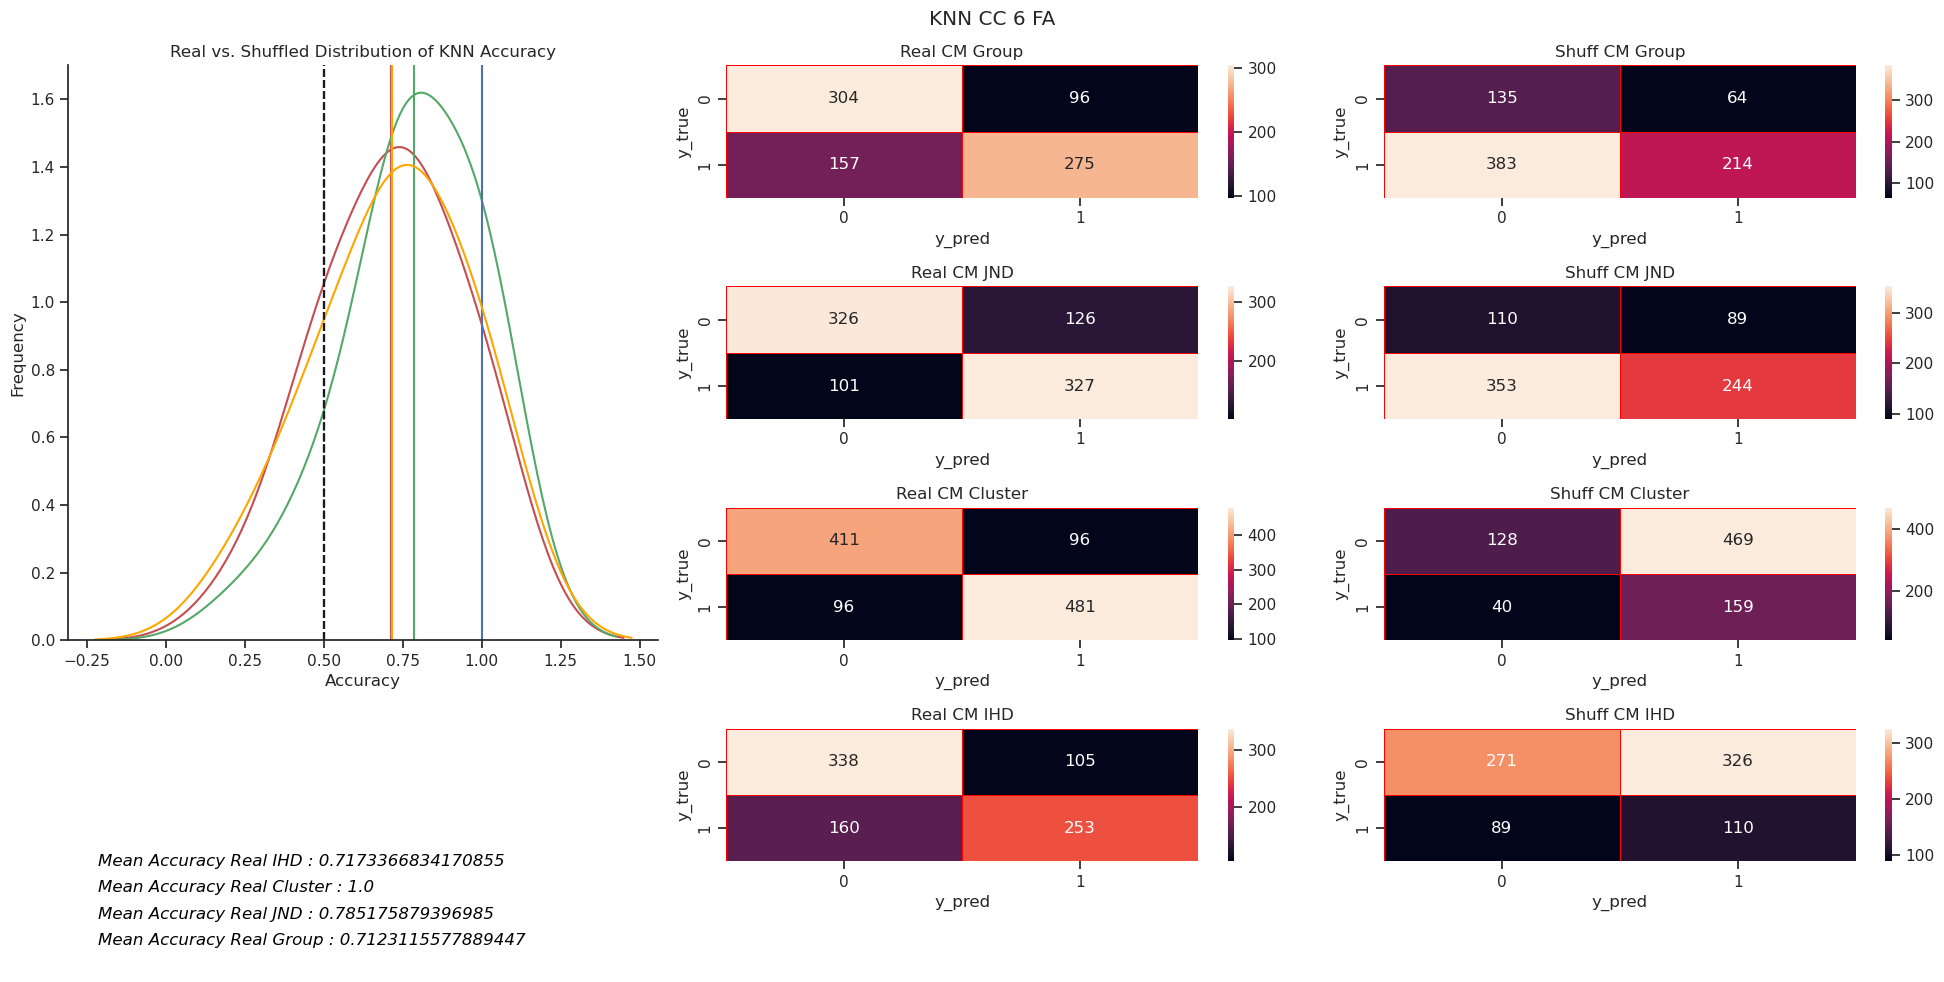

In [ ]:


# PLOT RESULTS KNN CLASSIFICATION and CONFUSION MATRIX and STATISTICS


targetVarStrList=['Group','JND','Cluster','IHD']

fig = plt.figure(tight_layout=True,figsize=(20,10))

gs = gridspec.GridSpec(9, 6)

bw_adjust=2

ax = fig.add_subplot(gs[0:6,0:2])


colorlist=['r','g','b','orange']

for i in range(0,4):
    #sns.kdeplot(data=accuracies_shuff_all[i,:], color=colorlist[i],ax=ax,bw_adjust=bw_adjust)
    sns.kdeplot(data=accuracies_real_all[i,:], color=colorlist[i],ax=ax,bw_adjust=bw_adjust)
    #ax.axvline(x=np.mean(accuracies_shuff_all[i,:]), color=colorlist[i], linestyle='--')
    ax.axvline(x=np.mean(accuracies_real_all[i,:]), color=colorlist[i], linestyle='-')
    ax.axvline(x=0.5, color='k', linestyle='--')


ax.set_xlabel('Accuracy')
ax.set_ylabel('Frequency')
ax.set_title('Real vs. Shuffled Distribution of KNN Accuracy')




ax.spines[['right', 'top']].set_visible(False)


for i in range(0,4):

    ax = fig.add_subplot(gs[0+i*2:2+2*i,2:4])
    ax2 = fig.add_subplot(gs[7:9,0:2])

    sns.heatmap(cm_real_all[:,:,i],annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
    ax.set_xlabel("y_pred")
    ax.set_ylabel("y_true")
    ax.set_title('Real CM ' + targetVarStrList[i])

    ax = fig.add_subplot(gs[0+i*2:2+2*i,4:6])

    sns.heatmap(cm_shuff_all[:,:,i],annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
    ax.set_xlabel("y_pred")
    ax.set_ylabel("y_true")
    ax.set_title('Shuff CM ' + targetVarStrList[i])

    Fontsize=12
#    ax2.text(0.05, 0.2+0.2*i,f'Mean Accuracy Real: {np.mean(accuracies_real_all[i,:]):.3f}',  style = 'italic',     fontsize = Fontsize,     color = "black") 
    ax2.text(0.05, 0.2+0.2*i,'Mean Accuracy Real ' + targetVarStrList[i] + ' : ' + str(np.mean(accuracies_real_all[i,:])),  style = 'italic',     fontsize = Fontsize,     color = "black") 

    ax2.set_axis_off()
    




             
from scipy.stats import ttest_1samp,ttest_ind

t_statistic, p_value = ttest_1samp(accuracies_real, 0.5,alternative='greater')
t_statistic2, p_value2 = ttest_ind(accuracies_real, accuracies_shuff)

#print(f'Mean Accuracy Real: {np.mean(accuracies_real):.2f}')
#print(f'Mean Accuracy Shuff: {np.mean(accuracies_shuff):.2f}')

#print(f'T-statistic: {t_statistic:.4f}')
#print(f'Accuracy Real Greater than 0.5 : P-value: {p_value:.4f}')
#print(f'T-statistic: {t_statistic2:.4f}')
#print(f'Accuracy Real vs Shuffle : P-value: {p_value2:.4f}')


fig.suptitle('KNN CC '+str(CC)+' '+dti_metric)

namefig='KNN CC '+str(CC)+' '+dti_metric +' All'

plt.tight_layout()

plt.savefig(namefig,format='pdf')

plt.show()



Text(0.5, 1.0, 'Real vs. Shuffled Distribution of KNN Recall')

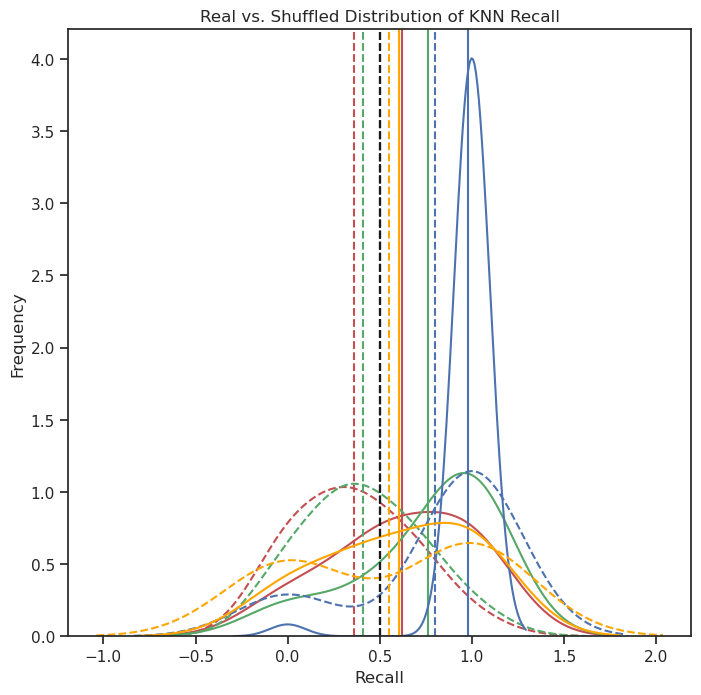

In [ ]:
Recall0=np.mean(recall_real_all[0,:])*100
Recall1=np.mean(recall_real_all[1,:])*100
Recall2=np.mean(recall_real_all[2,:])*100
Recall3=np.mean(recall_real_all[3,:])*100


fig = plt.figure(tight_layout=True,figsize=(20,10))

gs = gridspec.GridSpec(9, 6)

bw_adjust=2

ax = fig.add_subplot(gs[0:6,0:2])


colorlist=['r','g','b','orange']

for i in range(0,4):
    #sns.kdeplot(data=accuracies_shuff_all[i,:], color=colorlist[i],ax=ax,bw_adjust=bw_adjust)
    sns.kdeplot(data=recall_real_all[i,:], color=colorlist[i],ax=ax,bw_adjust=bw_adjust)
    sns.kdeplot(data=recall_shuff_all[i,:], color=colorlist[i],ax=ax,bw_adjust=bw_adjust,linestyle='--')
    ax.axvline(x=np.mean(recall_real_all[i,:]), color=colorlist[i], linestyle='-')
    ax.axvline(x=np.mean(recall_shuff_all[i,:]), color=colorlist[i], linestyle='--')
    ax.axvline(x=0.5, color='k', linestyle='--')


ax.set_xlabel('Recall')
ax.set_ylabel('Frequency')
ax.set_title('Real vs. Shuffled Distribution of KNN Recall')





In [ ]:

ax = fig.add_subplot(gs[2:5,0:3])

ax.set_axis_off()
Fontsize=12

ax.text(0.05, 0.9,r"$\bf{KNN  }$",   fontsize = Fontsize,     color = "black") 

ax.text(0.05, 0.8,f'Mean Accuracy Real: {np.mean(accuracies_real):.3f}',  style = 'italic',     fontsize = Fontsize,     color = "black") 
ax.text(0.05, 0.7,f'Mean Accuracy Shuff: {np.mean(accuracies_shuff):.2f}',  style = 'italic',     fontsize = Fontsize,     color = "black") 

ax.text(0.05, 0.5,f'T-statistic: {t_statistic:.4f}',  style = 'italic',     fontsize = 10,     color = "black") 
ax.text(0.05, 0.4,f'Accuracy Real Greater than 0.5 : P-value: {p_value:.4f}',  style = 'italic',     fontsize = Fontsize,     color = "black") 
ax.text(0.05, 0.25,f'T-statistic: {t_statistic2:.4f}',  style = 'italic',     fontsize = 10,     color = "black") 
ax.text(0.05, 0.15,f'Accuracy Real vs Shuffle : P-value: {p_value2:.4f}',  style = 'italic',     fontsize = Fontsize,     color = "black") 





Text(0.05, 0.15, 'Accuracy Real vs Shuffle : P-value: 0.0000')

In [ ]:


if make_jointplot==1:

    grid1=sns.jointplot(x="JND_P", y="IHD", data=SubjectTable, hue="group", height=4,kind="kde")
    grid1.ax_joint.set_title('KNN CC '+str(CC)+' '+dti_metric +' '+ targetVarStr, pad=70)
    grid2=sns.jointplot(x="JND_P", y="IHD", data=SubjectTable, hue="cluster", height=4,kind="kde")
    grid2.ax_joint.set_title('KNN CC '+str(CC)+' '+dti_metric +' '+ targetVarStr, pad=70)

    plt.tight_layout()

